In [20]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

Matplotlib version:  3.1.3


In [17]:
vnc_crime_df = pd.read_csv('https://raw.githubusercontent.com/RamanujaSVL/Coursera_Capstone/master/vancouver_crime_records_2018.csv', index_col=None)

#Dropping X,Y which represents Lat, Lng data as Coordinates, the data seems to be corrupt
vnc_crime_df.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vnc_crime_df.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


In [26]:
# define the dataframe columns
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
vnc_neighbour = pd.DataFrame(columns=column_names)

vnc_neighbour['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neighbour_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neighbour_dict, vnc_neighbour['Neighbourhood']):
  vnc_neighbour.loc[vnc_neighbour.Neighbourhood == row, 'Borough'] = neighbour_dict.get(row)

vnc_neighbour.dropna(inplace=True)
vnc_neighbour.head()

,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


In [32]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neighbour, on='Neighbourhood')
vnc_boroughs_crime.dropna(inplace=True) #Data Cleaning
vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,Central
1,Break and Enter Commercial,2018,6,16,18,West End,Central
2,Break and Enter Commercial,2018,12,12,0,West End,Central
3,Break and Enter Commercial,2018,3,2,3,West End,Central
4,Break and Enter Commercial,2018,3,17,11,West End,Central


In [34]:
vnc_crime_df['Neighbourhood'].value_counts()

Central Business District    10857
West End                      3031
Mount Pleasant                2396
Strathcona                    1987
Kitsilano                     1802
Fairview                      1795
Renfrew-Collingwood           1762
Grandview-Woodland            1761
Kensington-Cedar Cottage      1391
Hastings-Sunrise              1270
Sunset                         967
Riley Park                     866
Marpole                        828
Victoria-Fraserview            600
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    414
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   292
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

In [35]:
vnc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

In [36]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

In [37]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


In [41]:
vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh.head()

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                     12   
Central Business District                        551   
Dunbar-Southlands                                  8   
Fairview                                         138   
Grandview-Woodland                               148   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            78       49   
Central Business District                               124     1812   
Dunbar-Southlands                                       106       81   
Fairview                                                 73      233   
Grandview-Woodland                                      162      304   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      18                111               12   
Central Business District        2034               5301              640   
Dunbar-Southlands                  31                199               16   
Fairview                          297                692              245   
Grandview-Woodland                215                634              110   

                                            \
Type                      Theft of Vehicle   
Neighbourhood                                
Arbutus Ridge                           12   
Central Business District              165   
Dunbar-Southlands                        9   
Fairview                                55   
Grandview-Woodland                     123   

                                                                                  \
Type                      Vehicle Collision or Pedestrian Struck (with Fatality)   
Neighbourhood                                                                      
Arbutus Ridge                                                              1       
Central Business District                                                  0       
Dunbar-Southlands                                                          1       
Fairview                                                                   0       
Grandview-Woodland                                                         0       

                                                                                \
Type                      Vehicle Collision or Pedestrian Struck (with Injury)   
Neighbourhood                                                                    
Arbutus Ridge                                                             18     
Central Business District                                                230     
Dunbar-Southlands                                                         23     
Fairview                                                                  62     
Grandview-Woodland                                                        65     

                                  
Type                         All  
Neighbourhood                     
Arbutus Ridge                311  
Central Business District  10857  
Dunbar-Southlands            474  
Fairview                    1795  
Grandview-Woodland          1761

In [42]:
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
2,Dunbar-Southlands,8,106,81,31,199,16,9,1,23,474
3,Fairview,138,73,233,297,692,245,55,0,62,1795
4,Grandview-Woodland,148,162,304,215,634,110,123,0,65,1761


In [43]:
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
22,West End,230,72,460,455,1461,203,77,1,72,3031
11,Mount Pleasant,205,124,353,493,822,232,67,0,100,2396
19,Strathcona,160,124,527,81,821,108,76,2,88,1987
9,Kitsilano,106,165,320,154,755,189,51,1,61,1802


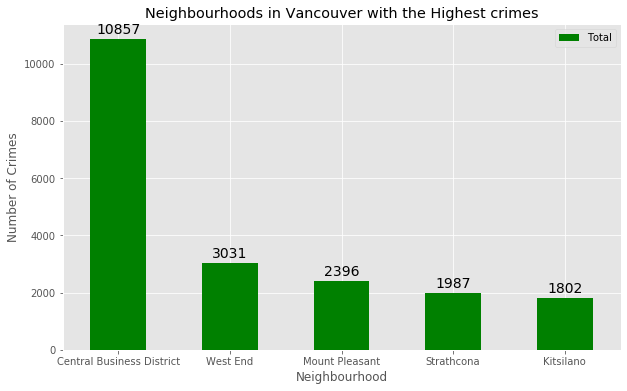

In [46]:
per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), color = 'green', rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [47]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

In [51]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


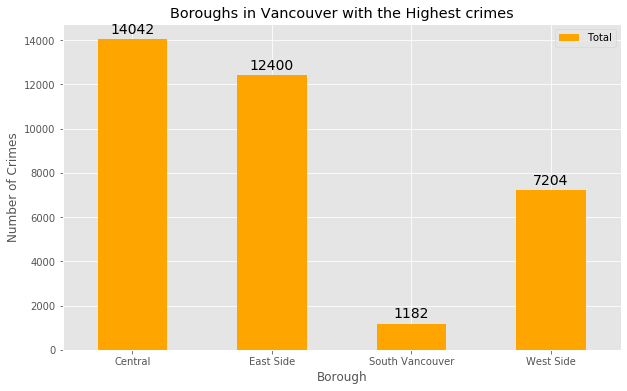

In [53]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), color = 'orange', rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

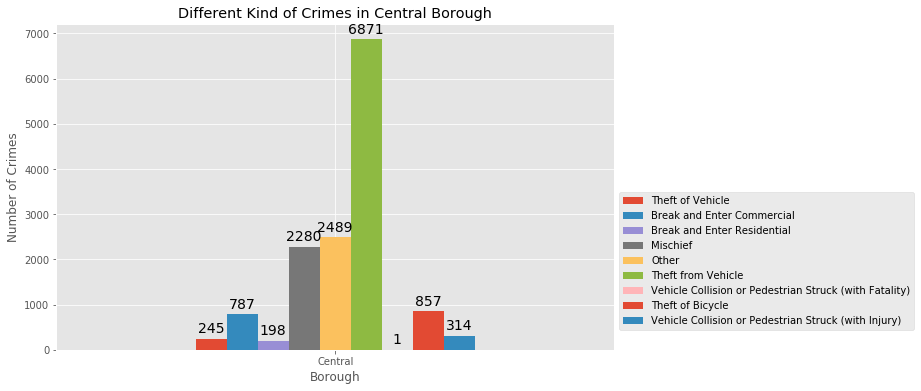

In [75]:
vnc_CN_df = vnc_crime_cat[vnc_crime_cat['Borough'] == 'Central']

vnc_CN_df = vnc_CN_df.sort_values(['Total'], ascending = True, axis = 0)

vnc_CN = vnc_CN_df[['Borough','Theft of Vehicle', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle','Vehicle Collision or Pedestrian Struck (with Fatality)','Theft of Bicycle',
                 'Vehicle Collision or Pedestrian Struck (with Injury)']]


vnc_CN.set_index('Borough',inplace = True)

ax = vnc_CN.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in Central Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighbourhood's co-ordinates.:
This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighbourhood by plotting it on maps using Folium and perform exploratory data analysis.

In [181]:
vnc_boroughs_crime['Neighbourhood'].unique()

array(['West End', 'Central Business District', 'Hastings-Sunrise',
       'Grandview-Woodland', 'Mount Pleasant', 'Strathcona',
       'Shaughnessy', 'Sunset', 'Fairview', 'Oakridge', 'Marpole',
       'Kensington-Cedar Cottage', 'Kitsilano', 'Victoria-Fraserview',
       'Kerrisdale', 'West Point Grey', 'Riley Park', 'Arbutus Ridge',
       'Renfrew-Collingwood', 'Killarney', 'South Cambie',
       'Dunbar-Southlands', 'Stanley Park', 'Musqueam'], dtype=object)

In [182]:
Latitude = []
Longitude = []
Borough = []
Neighbourhood = vnc_boroughs_crime['Neighbourhood'].unique()

# Key has been hidden
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('Borough')
print(Latitude, Longitude)

[49.2841308, 49.24966, 49.2775935, 49.2705588, 49.2633296, 49.279554, 49.2518626, 49.2195929, 49.2641128, 49.2308288, 49.2092233, 49.2476321, 49.2694099, 49.2184156, 49.2346728, 49.2644843, 49.2474381, 49.2409677, 49.2420242, 49.2242738, 49.2466847, 49.2534601, 49.3019112, 49.2346005] [-123.1317949, -123.11934, -123.0439199, -123.0679417, -123.0965885, -123.0899788, -123.1380226, -123.0902386, -123.1268352, -123.1311342, -123.1361495, -123.0842067, -123.155267, -123.0732871, -123.1553893, -123.1854326, -123.1029664, -123.1670008, -123.0576794, -123.0462504, -123.120915, -123.1850439, -123.1415405, -123.183397]


In [186]:
CN_neig_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
CN_neig_geo = pd.DataFrame(data=CN_neig_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

CN_neig_geo.drop(['Borough'], 1, inplace = True)

In [187]:
address = 'Vancouver, BC, Canada'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geographical coordinate of Vancouver, Canada are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Vancouver, Canada are 49.2608724, -123.1139529.


In [189]:
CN_neig_geo

,Neighbourhood,Latitude,Longitude
0,West End,49.284131,-123.131795
1,Central Business District,49.249660,-123.119340
2,Hastings-Sunrise,49.277594,-123.043920
3,Grandview-Woodland,49.270559,-123.067942
4,Mount Pleasant,49.263330,-123.096588
5,Strathcona,49.279554,-123.089979
6,Shaughnessy,49.251863,-123.138023
7,Sunset,49.219593,-123.090239
8,Fairview,49.264113,-123.126835
9,Oakridge,49.230829,-123.131134


In [185]:
vnc_boroughs_crime.reset_index(inplace = True)
vnc_boroughs_crime.head()

,index,Neighbourhood,Type,Year,Month,Day,Hour,Borough
0,0,West End,Break and Enter Commercial,2018,3,2,6,Central
1,1,West End,Break and Enter Commercial,2018,6,16,18,Central
2,2,West End,Break and Enter Commercial,2018,12,12,0,Central
3,3,West End,Break and Enter Commercial,2018,3,2,3,Central
4,4,West End,Break and Enter Commercial,2018,3,17,11,Central
...,...,...,...,...,...,...,...,...
34823,34823,Musqueam,Theft of Bicycle,2018,7,15,15,South Vancouver
34824,34824,Musqueam,Theft of Vehicle,2018,8,17,23,South Vancouver
34825,34825,Musqueam,Theft of Vehicle,2018,6,3,6,South Vancouver
34826,34826,Musqueam,Vehicle Collision or Pedestrian Struck (with I...,2018,6,15,17,South Vancouver


In [103]:
NBD = pd.merge(vnc_boroughs_crime, CN_neig_geo, on='Neighbourhood')

In [104]:
NBD

,Neighbourhood,Type,Year,Month,Day,Hour,Borough,Latitude,Longitude
0,West End,Break and Enter Commercial,2018,3,2,6,Central,49.284131,-123.131795
1,West End,Break and Enter Commercial,2018,6,16,18,Central,49.284131,-123.131795
2,West End,Break and Enter Commercial,2018,12,12,0,Central,49.284131,-123.131795
3,West End,Break and Enter Commercial,2018,3,2,3,Central,49.284131,-123.131795
4,West End,Break and Enter Commercial,2018,3,17,11,Central,49.284131,-123.131795
...,...,...,...,...,...,...,...,...,...
34823,Musqueam,Theft of Bicycle,2018,7,15,15,South Vancouver,49.234600,-123.183397
34824,Musqueam,Theft of Vehicle,2018,8,17,23,South Vancouver,49.234600,-123.183397
34825,Musqueam,Theft of Vehicle,2018,6,3,6,South Vancouver,49.234600,-123.183397
34826,Musqueam,Vehicle Collision or Pedestrian Struck (with I...,2018,6,15,17,South Vancouver,49.234600,-123.183397


In [106]:
# one hot encoding
NBD_onehot = pd.get_dummies(NBD[['Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NBD_onehot['Neighbourhood'] = NBD['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [NBD_onehot.columns[-1]] + list(NBD_onehot.columns[:-1])
NBD_onehot = NBD_onehot[fixed_columns]

NBD_onehot.head()

,Neighbourhood,Break and Enter Commercial,Break and Enter Residential/Other,Mischief,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
0,West End,1,0,0,0,0,0,0,0,0
1,West End,1,0,0,0,0,0,0,0,0
2,West End,1,0,0,0,0,0,0,0,0
3,West End,1,0,0,0,0,0,0,0,0
4,West End,1,0,0,0,0,0,0,0,0


In [108]:
NBD_onehot.shape

(34828, 10)

In [110]:
NBD_onehot_grouped = NBD_onehot.groupby('Neighbourhood').mean().reset_index()
NBD_onehot_grouped.head()

,Neighbourhood,Break and Enter Commercial,Break and Enter Residential/Other,Mischief,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
0,Arbutus Ridge,0.038585,0.250804,0.157556,0.057878,0.356913,0.038585,0.038585,0.003215,0.057878
1,Central Business District,0.050751,0.011421,0.166897,0.187345,0.488256,0.058948,0.015198,0.000000,0.021184
2,Dunbar-Southlands,0.016878,0.223629,0.170886,0.065401,0.419831,0.033755,0.018987,0.002110,0.048523
3,Fairview,0.076880,0.040669,0.129805,0.165460,0.385515,0.136490,0.030641,0.000000,0.034540
4,Grandview-Woodland,0.084043,0.091993,0.172629,0.122090,0.360023,0.062465,0.069847,0.000000,0.036911


In [111]:
#Top 5 crimes
num_top_venues = 5

for hood in NBD_onehot_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = NBD_onehot_grouped[NBD_onehot_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['Type','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
                                                Type  freq
0                                 Theft from Vehicle  0.36
1                  Break and Enter Residential/Other  0.25
2                                           Mischief  0.16
3                                        Other Theft  0.06
4  Vehicle Collision or Pedestrian Struck (with I...  0.06


----Central Business District----
                         Type  freq
0          Theft from Vehicle  0.49
1                 Other Theft  0.19
2                    Mischief  0.17
3            Theft of Bicycle  0.06
4  Break and Enter Commercial  0.05


----Dunbar-Southlands----
                                                Type  freq
0                                 Theft from Vehicle  0.42
1                  Break and Enter Residential/Other  0.22
2                                           Mischief  0.17
3                                        Other Theft  0.07
4  Vehicle Collision or Pedestrian Struck (with I

Create the new dataframe and display the top 10 Crimes for each neighborhood.

In [166]:
num_top_crimes = 10

# create columns according to number of top crimes
columns = ['Neighbourhood']
for ind in np.arange(num_top_crimes):
    columns.append('No.{} Most Common Crime'.format(ind))

# create a new dataframe
neighborhoods_crimes_sorted = pd.DataFrame(columns=columns)
neighborhoods_crimes_sorted['Neighbourhood'] = NBD_onehot_grouped['Neighbourhood']
neighborhoods_crimes_sorted.shape

(24, 11)

In [164]:
np.arange(NBD_onehot_grouped.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [165]:
def return_most_common_crimes(row, num_top_crimes):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_crimes]

In [169]:
for ind in np.arange(NBD_onehot_grouped.shape[0]):
    neighborhoods_crimes_sorted.iloc[ind, 2:] = return_most_common_crimes(NBD_onehot_grouped.iloc[ind, :], num_top_crimes)

neighborhoods_crimes_sorted.drop('No.0 Most Common Crime', axis=1, inplace=True)

In [171]:
neighborhoods_crimes_sorted.head()

,Neighbourhood,No.1 Most Common Crime,No.2 Most Common Crime,No.3 Most Common Crime,No.4 Most Common Crime,No.5 Most Common Crime,No.6 Most Common Crime,No.7 Most Common Crime,No.8 Most Common Crime,No.9 Most Common Crime
0,Arbutus Ridge,Theft from Vehicle,Break and Enter Residential/Other,Mischief,Vehicle Collision or Pedestrian Struck (with I...,Other Theft,Theft of Vehicle,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
1,Central Business District,Theft from Vehicle,Other Theft,Mischief,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with F...
2,Dunbar-Southlands,Theft from Vehicle,Break and Enter Residential/Other,Mischief,Other Theft,Vehicle Collision or Pedestrian Struck (with I...,Theft of Bicycle,Theft of Vehicle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
3,Fairview,Theft from Vehicle,Other Theft,Theft of Bicycle,Mischief,Break and Enter Commercial,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with F...
4,Grandview-Woodland,Theft from Vehicle,Mischief,Other Theft,Break and Enter Residential/Other,Break and Enter Commercial,Theft of Vehicle,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with I...,Vehicle Collision or Pedestrian Struck (with F...


In [172]:
# set number of clusters
kclusters = 5

NBC_grouped_clustering = NBD_onehot_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NBC_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 4, 3, 1, 1, 1, 4, 1, 1])

In [173]:
# add clustering labels
neighborhoods_crimes_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = CN_neig_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_crimes_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vancouver_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,No.1 Most Common Crime,No.2 Most Common Crime,No.3 Most Common Crime,No.4 Most Common Crime,No.5 Most Common Crime,No.6 Most Common Crime,No.7 Most Common Crime,No.8 Most Common Crime,No.9 Most Common Crime
0,West End,49.284131,-123.131795,3,Theft from Vehicle,Mischief,Other Theft,Break and Enter Commercial,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with I...,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with F...
1,Central Business District,49.249660,-123.119340,3,Theft from Vehicle,Other Theft,Mischief,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with F...
2,Hastings-Sunrise,49.277594,-123.043920,1,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Other Theft,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with I...,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
3,Grandview-Woodland,49.270559,-123.067942,1,Theft from Vehicle,Mischief,Other Theft,Break and Enter Residential/Other,Break and Enter Commercial,Theft of Vehicle,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with I...,Vehicle Collision or Pedestrian Struck (with F...
4,Mount Pleasant,49.263330,-123.096588,3,Theft from Vehicle,Other Theft,Mischief,Theft of Bicycle,Break and Enter Commercial,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with F...


In [174]:
latitude, longitude

(49.2608724, -123.1139529)

In [175]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b>Analysis of each cluster</b>

Cluster 1

In [196]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[0] + list(range(4, vancouver_merged.shape[1]))]]

,Neighbourhood,No.1 Most Common Crime,No.2 Most Common Crime,No.3 Most Common Crime,No.4 Most Common Crime,No.5 Most Common Crime,No.6 Most Common Crime,No.7 Most Common Crime,No.8 Most Common Crime,No.9 Most Common Crime
23,Musqueam,Theft from Vehicle,Break and Enter Residential/Other,Mischief,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with F...,Other Theft,Break and Enter Commercial


Cluster 2

In [200]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[0] + list(range(4, vancouver_merged.shape[1]))]]

,Neighbourhood,No.1 Most Common Crime,No.2 Most Common Crime,No.3 Most Common Crime,No.4 Most Common Crime,No.5 Most Common Crime,No.6 Most Common Crime,No.7 Most Common Crime,No.8 Most Common Crime,No.9 Most Common Crime
2,Hastings-Sunrise,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Other Theft,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with I...,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
3,Grandview-Woodland,Theft from Vehicle,Mischief,Other Theft,Break and Enter Residential/Other,Break and Enter Commercial,Theft of Vehicle,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with I...,Vehicle Collision or Pedestrian Struck (with F...
5,Strathcona,Theft from Vehicle,Mischief,Break and Enter Commercial,Break and Enter Residential/Other,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with I...,Other Theft,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with F...
7,Sunset,Theft from Vehicle,Mischief,Other Theft,Vehicle Collision or Pedestrian Struck (with I...,Break and Enter Residential/Other,Theft of Vehicle,Break and Enter Commercial,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with F...
10,Marpole,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Other Theft,Break and Enter Commercial,Theft of Vehicle,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with F...
11,Kensington-Cedar Cottage,Theft from Vehicle,Mischief,Other Theft,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
12,Kitsilano,Theft from Vehicle,Mischief,Theft of Bicycle,Break and Enter Residential/Other,Other Theft,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with F...
13,Victoria-Fraserview,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Other Theft,Theft of Vehicle,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
16,Riley Park,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Other Theft,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with F...
19,Killarney,Theft from Vehicle,Mischief,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Break and Enter Commercial,Theft of Vehicle,Other Theft,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with F...


In [206]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[0] + list(range(4, vancouver_merged.shape[1]))]]['Neighbourhood'].tolist()

['West End',
 'Central Business District',
 'Mount Pleasant',
 'Fairview',
 'Renfrew-Collingwood']

Cluster 3

In [205]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] ==2, vancouver_merged.columns[[0] + list(range(4, vancouver_merged.shape[1]))]]

,Neighbourhood,No.1 Most Common Crime,No.2 Most Common Crime,No.3 Most Common Crime,No.4 Most Common Crime,No.5 Most Common Crime,No.6 Most Common Crime,No.7 Most Common Crime,No.8 Most Common Crime,No.9 Most Common Crime
22,Stanley Park,Theft from Vehicle,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with I...,Mischief,Break and Enter Commercial,Theft of Vehicle,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with F...,Other Theft


Cluster 4

In [199]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[0] + list(range(4, vancouver_merged.shape[1]))]]

,Neighbourhood,No.1 Most Common Crime,No.2 Most Common Crime,No.3 Most Common Crime,No.4 Most Common Crime,No.5 Most Common Crime,No.6 Most Common Crime,No.7 Most Common Crime,No.8 Most Common Crime,No.9 Most Common Crime
0,West End,Theft from Vehicle,Mischief,Other Theft,Break and Enter Commercial,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with I...,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with F...
1,Central Business District,Theft from Vehicle,Other Theft,Mischief,Theft of Bicycle,Break and Enter Commercial,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with F...
4,Mount Pleasant,Theft from Vehicle,Other Theft,Mischief,Theft of Bicycle,Break and Enter Commercial,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with F...
8,Fairview,Theft from Vehicle,Other Theft,Theft of Bicycle,Mischief,Break and Enter Commercial,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with F...
18,Renfrew-Collingwood,Theft from Vehicle,Other Theft,Mischief,Break and Enter Residential/Other,Vehicle Collision or Pedestrian Struck (with I...,Theft of Vehicle,Break and Enter Commercial,Theft of Bicycle,Vehicle Collision or Pedestrian Struck (with F...
